In [1]:
import librosa
import librosa.display
import pydub
import pandas as pd
import numpy as np
import glob
import os

import torch
import torchaudio
from matplotlib import pyplot as plt
import seaborn as sns
import random

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


# Utility Functions

In [2]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

# Load files & EDA

In [3]:
wave_files = glob.glob('data/cats_dogs/*.wav')
df = pd.read_csv('data/train_test_split.csv')

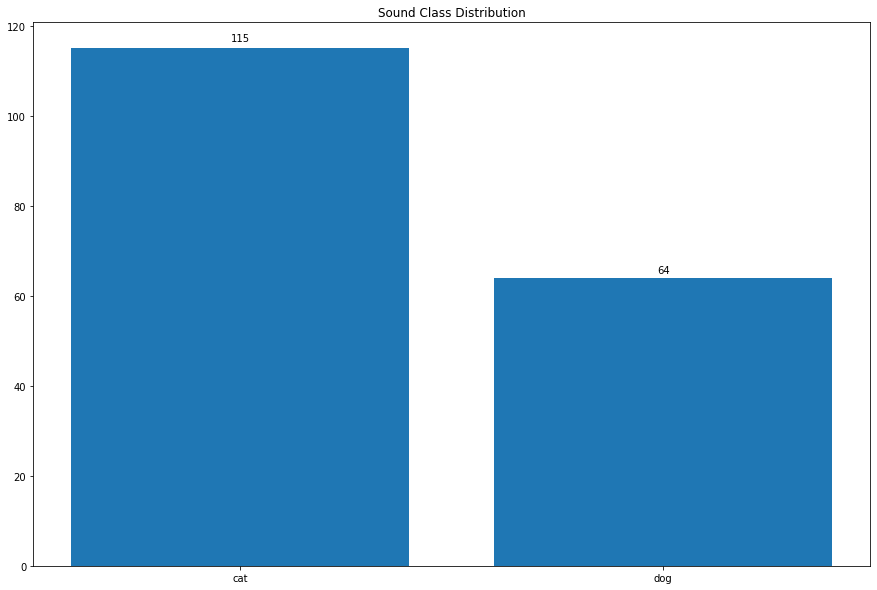

In [4]:
# View class distribution quite uneven
values = [df[~df['train_cat'].isnull()].shape[0], df[~df['train_dog'].isnull()].shape[0]]

plt.figure(figsize=(15, 10))
plt.title('Sound Class Distribution')
bars = plt.bar(['cat', 'dog'], values)
autolabel(bars)

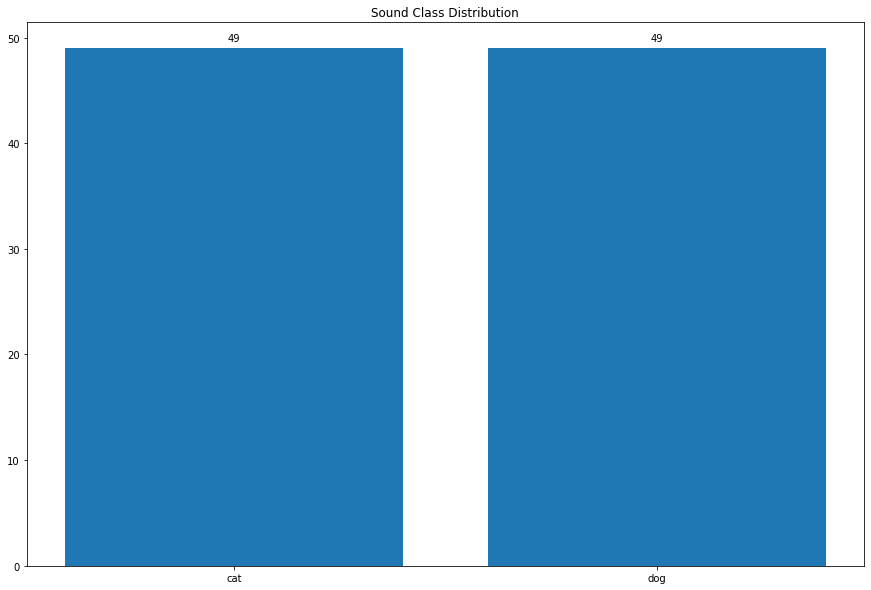

In [5]:
values = [df[~df['test_cat'].isnull()].shape[0], df[~df['test_dog'].isnull()].shape[0]]

plt.figure(figsize=(15, 10))
plt.title('Sound Class Distribution')
bars = plt.bar(['cat', 'dog'], values)
autolabel(bars)

# Lets view our sound files

In [15]:
sound_waves = {
    'wave_form': [],
    'labels': [],
    'sample_rate': []
}

normalize = True

for wave_file in wave_files:
    wave_form, sr = torchaudio.load(wave_file)
    
    if normalize:
        # Pad waveform
        num_rows, sig_len = wave_form.shape
        max_len = sr // 1000 * 7000 # ms
        if sig_len > max_len:
            # Truncate
            wave_form[:, :max_len]
        elif sig_len < max_len:
            # Pad
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # pads with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            wave_form = torch.cat([pad_begin, wave_form, pad_end], 1)
    
    sound_waves['wave_form'].append(wave_form)
    sound_waves['labels'].append(os.path.basename(wave_file)[:3])
    sound_waves['sample_rate'].append(sr)

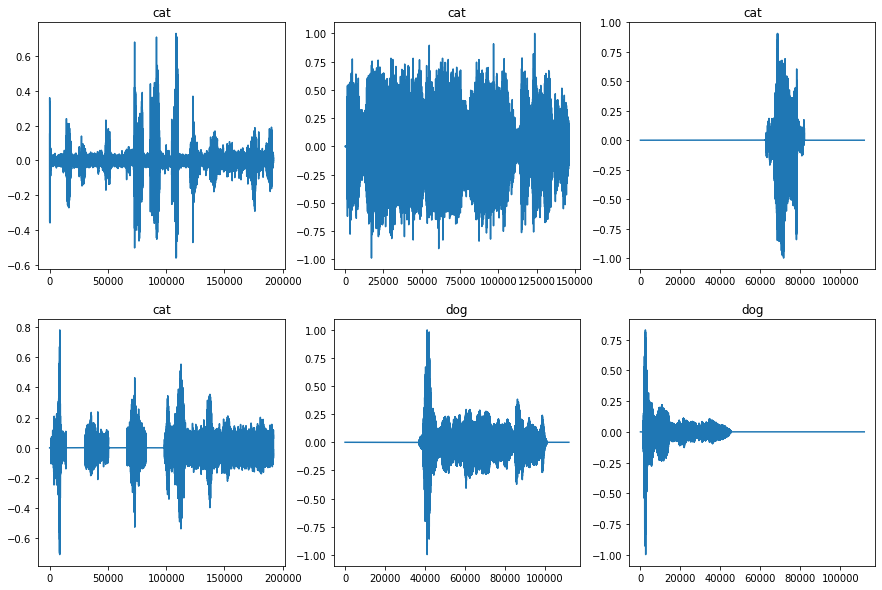

In [16]:
random_index = np.random.randint(0, len(sound_waves['labels']), (6,))

plt.figure(figsize=(15, 10))
count = 0
for index in random_index:
    count += 1
    plt.subplot(2, 3, count)
    plt.title(sound_waves['labels'][index])
    plt.plot(sound_waves['wave_form'][index].squeeze(0))

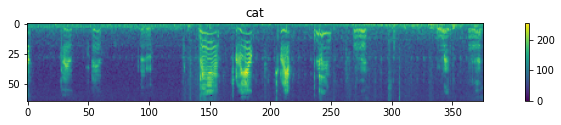

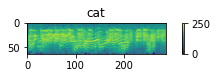

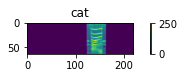

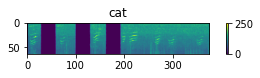

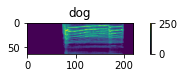

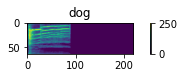

In [35]:
# Transform to spectogram
count = 0
plt.figure(figsize=(15, 10))
for index in random_index:
    count += 1
    plt.subplot(6, 1, count)
    plt.title(sound_waves['labels'][index])
    spec_gram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sound_waves['sample_rate'][index],
        n_fft=1024, hop_length=None, n_mels=64
    )(sound_waves['wave_form'][index])
    
    spec_gram = torchaudio.transforms.AmplitudeToDB(top_db=80)(spec_gram)
#     plt.imshow(spec_gram[0, :, :].numpy().astype(np.uint8))
    spec = spec_gram.numpy()
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + 1e-6)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    plt.imshow(spec_scaled[0])
    plt.colorbar()
    plt.show()

In [14]:
rand_file = np.random.choice(wave_files)
print(rand_file)
pydub.AudioSegment.from_wav(rand_file)

data/cats_dogs/dog_barking_6.wav
